In [1]:
%matplotlib ipympl
import os
import time
import pandas
import traceback
from onix.data_tools import get_experiment_data, open_analysis_folder, get_analysis_file_path
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from onix.helpers import present_float
from onix.models.schiff import inverse_fa_limit, axion_frequency_to_mass, axion_mass_to_frequency
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile
import allantools
from tqdm import tqdm
from uncertainties import ufloat, unumpy
from scipy.stats import pearsonr
from allantools import adev, mdev
from astropy.timeseries import LombScargle
from scipy.stats import norm
from onix.analysis.functions.lf_ramsey_shared import analyze_data
from onix.analysis.functions.lf_spectroscopy_quick_state_prep_axion import get_results
from onix.papers.axion_2024.lomb_scargle import frequency_sensitivity_from_experiment_times, ls_psd_to_power_spectrum

## long term phase scan

In [57]:
data_range = (4787037, 4787044)
first = data_range[0]
last = 5019644
results, col_indices = analyze_data(data_range, last, get_results)

new analysis
Existing data loaded


In [58]:
start_time_limit = 1722730400
start_mask = results[:, col_indices["start_time"]] > start_time_limit

data_spacing_time_upper_limit = 10
remove_data_points_before = 5
remove_data_points_after = 10
data_spacing_times = np.append(0, results[:, col_indices["start_time"]][1:] - results[:, col_indices["start_time"]][:-1])
data_spacing_times = data_spacing_times.astype(float)
data_spacing_time_discard_mask = data_spacing_times > data_spacing_time_upper_limit
data_spacing_time_mask = np.ones(len(results), dtype=bool)
for kk in data_spacing_time_discard_mask.nonzero()[0]:
    data_spacing_time_mask[np.arange(kk - remove_data_points_before, kk + remove_data_points_after)] = False

sigmas = 6  # unused
f_p = unumpy.nominal_values(results[:, col_indices["f+"]])
f_p_std = np.std(f_p)
f_p_avg = np.average(f_p)
f_p_mask = (f_p < f_p_std * sigmas + f_p_avg) & (f_p > -f_p_std * sigmas + f_p_avg)
f_m = unumpy.nominal_values(results[:, col_indices["f-"]])
f_m_std = np.std(f_m)
f_m_avg = np.average(f_m)
f_m_mask = (f_m < f_m_std * sigmas + f_m_avg) & (f_m > -f_m_std * sigmas + f_m_avg)
W_T = unumpy.nominal_values(results[:, col_indices["W_T"]])
W_T_std = np.std(W_T)
W_T_avg = np.average(W_T)
W_T_mask = (W_T < W_T_std * sigmas + W_T_avg) & (W_T > -W_T_std * sigmas + W_T_avg)

mask = start_mask & data_spacing_time_mask
print(len(results), np.sum(start_mask), np.sum(mask))

29073 29073 28075


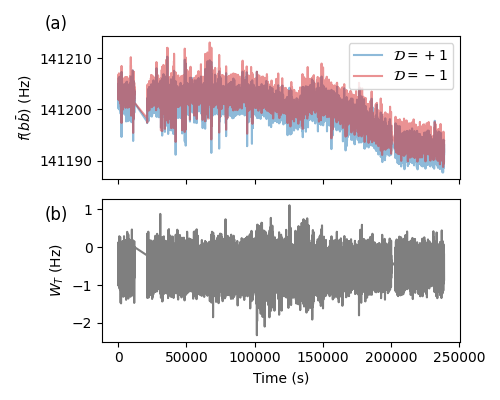

In [59]:
start_times = results[mask, col_indices["start_time"]].astype(float)
end_times = results[mask, col_indices["end_time"]].astype(float)

center_times = (start_times + end_times) / 2
center_time_offset = center_times[0]
center_time_offsetted = center_times - center_time_offset
cycle_times = end_times - start_times
num_of_cycles = len(start_times)
total_duration = end_times[-1] - start_times[0]

f_ps = unumpy.nominal_values(results[mask, col_indices["f+"]])
f_ms = unumpy.nominal_values(results[mask, col_indices["f-"]])
W_Ts = unumpy.nominal_values(results[mask, col_indices["W_T"]])

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(5, 4))
axs[0].set_ylabel("$f(b\\bar{b})$ (Hz)")
axs[1].set_ylabel("$W_T$ (Hz)")
axs[1].set_xlabel("Time (s)")

axs[0].plot(
    center_time_offsetted,
    f_ps,
    label="$\\mathcal{D}=+1$",
    color="C0",
    alpha=0.5,
)
axs[0].plot(
    center_time_offsetted,
    f_ms,
    label="$\\mathcal{D}=-1$",
    color="C3",
    alpha=0.5,
)
axs[0].text(-0.16, 1.05, "(a)", transform=axs[0].transAxes, fontsize=12)
axs[0].legend()
axs[1].plot(
    center_time_offsetted,
    W_Ts,
    color="C7",
)
axs[1].text(-0.16, 0.85, "(b)", transform=axs[1].transAxes, fontsize=12)
plt.tight_layout()
plt.savefig("time-series.pdf")
plt.show()

In [62]:
cycle_frequency_avg = 1 / np.average(cycle_times)
W_T_unc = np.std(W_Ts) / np.sqrt(num_of_cycles)

print(f'#{first} - #{last}')
print(f"Time: {total_duration:.1f} s, N_cycle = {num_of_cycles}")
print(f"Cycle time (laser unlock time not included): {np.average(cycle_times):.2f} s, cycle frequency {cycle_frequency_avg:.2f} Hz")
print("W_T =", present_float(np.average(W_T * 1e3), W_T_unc * 1e3, 2), "mHz")
print(f"W_T_unc sensitivity = {W_T_unc * 1e3 / np.sqrt(3600 / total_duration):.1f} mHz sqrt(hr)")
print(f"W_T_unc per cycle = {W_T_unc * np.sqrt(num_of_cycles):.2f} Hz")

#4787037 - #5019644
Time: 239160.8 s, N_cycle = 28075
Cycle time (laser unlock time not included): 6.77 s, cycle frequency 0.15 Hz
W_T = -534.9(1.9) mHz
W_T_unc sensitivity = 15.1 mHz sqrt(hr)
W_T_unc per cycle = 0.31 Hz


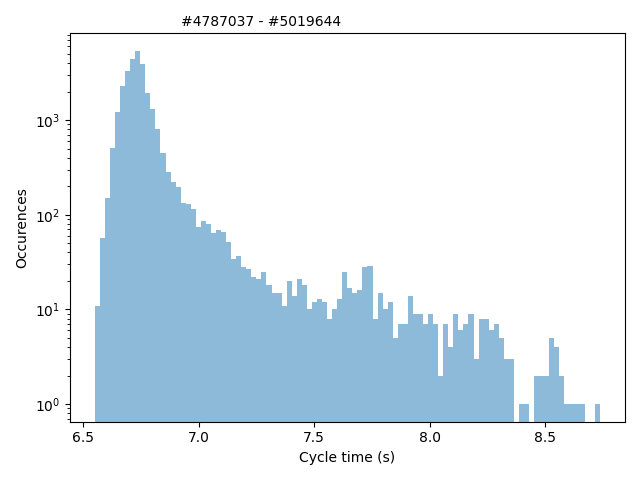

In [64]:
fig, ax = plt.subplots()
ax.text(0.2, 1.02, f'#{first} - #{last}', transform = ax.transAxes)
ax.hist(cycle_times, bins=100, alpha=0.5)
ax.set_xlabel("Cycle time (s)")
ax.set_ylabel("Occurences")
ax.set_yscale("log")
plt.tight_layout()
plt.show()

## cycle time simulation

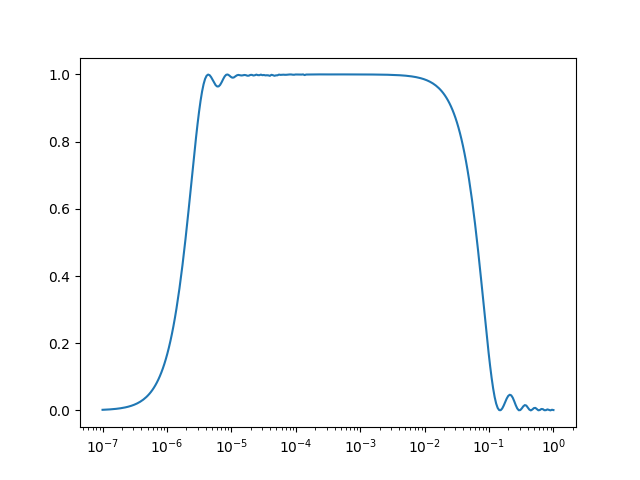

In [66]:
freqs_test = np.logspace(-7, 0, 300)
sensitivity_func = frequency_sensitivity_from_experiment_times(start_times, end_times, freqs_test)
fig, ax = plt.subplots()
ax.plot(freqs_test, sensitivity_func(freqs_test))
ax.set_xscale("log")
plt.show()

## Other experiments

In [79]:
nedm_beam = [
    [0.00002094366253972675, 9.228184717621306e-13],
    [0.0000381574151682107, 9.228184717621306e-13],
    [0.000059027261020128765, 9.228184717621306e-13],
    [0.0000964296357589575, 8.515939318253872e-13],
    [0.00015753186734235167, 7.252122247218192e-13],
    [0.00024369246741724016, 6.175863298586903e-13],
    [0.00037697781203116135, 6.692392369210013e-13],
    [0.0006158482110660254, 6.692392369210013e-13],
    [0.0009526807029019798, 6.692392369210013e-13],
    [0.0013214557699755313, 8.515939318253872e-13],
    [0.002044213800044953, 1.1742685834509335e-12],
    [0.0028355125834966634, 1.2724805792071611e-12],
    [0.0037243683865199727, 1.6192068244593855e-12],
    [0.005455594781168515, 2.0604092378442498e-12],
    [0.00756741180992021, 3.61525999011051e-12],
    [0.010496696290308766, 3.917628548556415e-12],
    [0.0145598833231919, 6.873996431179536e-12],
    [0.020195897501643818, 7.448915080832346e-12],
    [0.028013567611988584, 1.206133413370207e-11],
    [0.03679505646173878, 1.4163245747710605e-11],
    [0.04832930238571772, 1.952979454137516e-11],
    [0.06703718811765348, 2.4851284269805712e-11],
    [0.09298674652605253, 4.0239369086249256e-11],
    [0.13621048092382448, 5.54863358814511e-11],
    [0.18893646675075929, 7.060528482051168e-11],
    [0.27676123707542194, 1.1432455902426976e-10],
    [0.40541026126291946, 1.576429011081879e-10],
    [0.5938601867590265, 2.3555537752607464e-10],
    [0.7800191466090061, 2.997396432297385e-10],
    [1.1426013605028777, 4.478811562346004e-10],
    [1.584893192461111, 6.692392369209985e-10],
    [2.198392648862294, 1.000000000000004e-9],
    [3.049372829387252, 1.272480579207161e-9],
    [4.229760619613387, 1.901383704071991e-9],
    [5.555675127637383, 2.841112115332298e-9],
    [8.138161719423081, 4.24528622739387e-9],
    [10.689253297133892, 7.4489150808323455e-9],
    [14.040042455483146, 1.1130421932675274e-8],
    [18.441212559218194, 1.8022455152500004e-8],
    [22.936456081891755, 3.1622776601683924e-8],
    [30.126409040604397, 5.5486335881451094e-8],
    [39.570216010761904, 9.735810072368103e-8],
    [49.21588093881258, 1.7082763938087155e-7],
    [61.21278023664565, 3.2480888972387457e-7],
    [80.40131611167858, 4.85340475878609e-7],
    [105.60493425554463, 8.515939318253855e-7],
    [138.70919878509272, 0.000001494233967214404],
    [172.5210549942039, 0.00000241947383705256],
    [226.60169698035224, 0.0000046003481262002506],
    [281.8382931264449, 0.000008071918051887916],
    [350.53940253287334, 0.000014163245747710575],
    [435.98714484470514, 0.000021163202882234068],
    [542.2636916031483, 0.00003426760253433159],
    [712.2485584859892, 0.000060127032107950375],
    [885.8667904100796, 0.00006515586103639387],
]
nedm = [
    [2.5407309482131215e-10, 1.0000000000000082e-21],
    [8.920993504230511e-10, 1.0000000000000082e-21],
    [1.7698395026962515e-9, 1.281694235747855e-21],
    [2.9585191188514643e-9, 1.6427401139492514e-21],
    [6.965867456138822e-9, 4.081111338594443e-21],
    [2.5895430805858874e-8, 1.4115640814419625e-20],
    [6.455313751207961e-8, 3.80923988807601e-20],
    [1.2096079377043693e-7, 6.797282647900582e-20],
    [2.140811910924135e-7, 1.2129204973433053e-19],
    [4.011490657756674e-7, 2.1643592139424956e-19],
    [4.760865917562338e-7, 3.013296840132008e-19],
    [0.0000011209513822936697, 6.344467975683145e-19],
    [0.0000021004582303213126, 1.4510308524909214e-18],
    [0.0000031323318653041017, 2.194407936299421e-18],
    [0.0000044119247773245394, 2.5892480192909607e-18],
    [0.000006965867456138822, 3.318624261246748e-18],
    [0.000011644362111352868, 5.451637197075144e-18],
    [0.000020608652048371832, 9.728008739571699e-18],
    [0.00003445006793326692, 1.5980590185343195e-17],
    [0.00006834562884722594, 2.6251956542046538e-17],
    [0.00014355713861864203, 5.5273246021372644e-17],
    [0.00030153577333290294, 1.2641435909477686e-16],
    [0.000670573336621022, 2.661642365470368e-16],
    [0.0011868071806067108, 5.159110742628392e-16],
    [0.0018738174228603867, 9.206018775356789e-16],
    [0.0024928389103097874, 1.7844196867669167e-15],
    [0.0031323318653041017, 3.458773761188599e-15],
    [0.0035111917342151417, 4.433090392471319e-15],
]
hff = [
    [2.29364560818918e-8, 1.7546320040251268e-15],
    [0.23499175870246086, 1.8022455152500004e-8],
]
rb_quartz = [
    [0.0012565320014660888, 7.109709432312423e-11],
    [0.0013819612567338303, 6.255993607717648e-11],
    [0.0016092057297269024, 6.528521141127848e-11],
    [0.001803841387132263, 7.109709432312423e-11],
    [0.0020608652048371835, 7.742636826811278e-11],
    [0.0023101297000831652, 7.742636826811278e-11],
    [0.00268999867519594, 8.079926448382976e-11],
    [0.002902751895691752, 8.799225435691075e-11],
    [0.0032538437499312367, 9.182542835656263e-11],
    [0.0037174739497861085, 9.582558549602639e-11],
    [0.004247165392508592, 1.0435626297753924e-10],
    [0.0046711249825227815, 1.1364636663857289e-10],
    [0.0053366992312063235, 1.2376350284724787e-10],
    [0.005982180380106287, 1.3478129649084582e-10],
    [0.006579332246575696, 1.4065272421052392e-10],
    [0.007516801086146114, 1.531740463702086e-10],
    [0.008425968567942036, 1.6681005372000558e-10],
    [0.009267063710089816, 1.8165997883753285e-10],
    [0.010790904554926322, 2.0644996558525652e-10],
    [0.012565320014660888, 2.2482875308089988e-10],
    [0.014912612020020732, 2.6664038389397213e-10],
    [0.017037464293995625, 2.903775007273512e-10],
    [0.02022018496344441, 3.3000347911252887e-10],
    [0.023101297000831675, 3.5938136638046403e-10],
    [0.024928389103097928, 3.913745601980392e-10],
    [0.02589543080585882, 4.262158829015325e-10],
    [0.030732883225297405, 4.6415888336127913e-10],
    [0.036474006492530416, 5.274997063702631e-10],
    [0.04411924777324531, 6.255993607717649e-10],
    [0.05336699231206324, 6.528521141127848e-10],
    [0.05982180380106293, 7.419427072122866e-10],
    [0.06455313751207961, 8.43190929286625e-10],
    [0.07099694630794716, 8.43190929286625e-10],
    [0.07808398753833301, 9.182542835656263e-10],
    [0.0875283537660959, 9.58255854960264e-10],
    [0.1000000000000002, 1.0890229622637282e-9],
    [0.11868071806067107, 1.237635028472479e-9],
    [0.1355911689803108, 1.347812964908458e-9],
    [0.14355713861864144, 1.5317404637020798e-9],
    [0.1640121542811977, 1.6681005372000556e-9],
    [0.18038413871322628, 1.9783188827841624e-9],
    [0.20608652048371834, 2.154434690031878e-9],
    [0.23101297000831675, 2.154434690031878e-9],
    [0.2540730948213127, 2.7825594022071145e-9],
    [0.2848035868435811, 2.9037750072735e-9],
    [0.33163560958187915, 3.3000347911252885e-9],
    [0.3935875227966571, 3.913745601980376e-9],
    [0.45830756379546267, 4.641588833612773e-9],
    [0.5439227076388211, 5.744592928245907e-9],
    [0.609710910988652, 7.109709432312424e-9],
    [0.7236092872555898, 8.43190929286625e-9],
    [0.8267141516100122, 1.0435626297753882e-8],
    [0.9267063710089835, 1.1364636663857243e-8],
    [0.9626558943926876, 1.598467106434315e-8],
    [0.9811502914399474, 2.2482875308089944e-8],
    [1.0387927875628662, 1.9783188827841582e-8],
    [1.0387927875628662, 1.2915496650148827e-8],
    [1.2096079377043694, 1.2376350284724788e-8],
    [1.4631513629574142, 1.2376350284724788e-8],
    [1.769839502696248, 1.4065272421052335e-8],
    [1.8738174228603868, 1.7407673833302313e-8],
    [2.0220184963444408, 1.7407673833302313e-8],
    [2.100458230321317, 1.4677992676220675e-8],
    [2.4458496233632787, 1.5317404637020767e-8],
    [2.4928389103097928, 2.448436746822224e-8],
    [3.57864821001286, 2.78255940220712e-8],
    [4.496685997870486, 3.443792984976973e-8],
    [5.650229856868728, 4.0842386526745094e-8],
    [6.5793322465756825, 4.447829676127621e-8],
    [7.375111576368342, 3.9137456019803764e-8],
    [8.920993504230493, 4.641588833612763e-8],
    [10.387927875628684, 5.2749970637026086e-8],
    [11.424869279186124, 7.109709432312424e-8],
    [12.565320014660916, 7.419427072122835e-8],
    [13.559116898031078, 7.419427072122835e-8],
    [14.912612020020733, 6.52852114112782e-8],
    [15.788726707083754, 6.52852114112782e-8],
    [16.092057297269008, 8.431909292866217e-8],
    [18.384965105447158, 7.742636826811246e-8],
    [21.408119109241305, 8.799225435691039e-8],
    [22.238599725966637, 1.089022962263726e-7],
    [25.407309482131215, 1.0435626297753882e-7],
    [28.480358684358105, 1.089022962263726e-7],
    [31.32331865304108, 1.2376350284724763e-7],
    [37.88893487796167, 1.5984671064343147e-7],
    [42.47165392508597, 1.8957356524063675e-7],
    [48.523309416493845, 2.346228848142253e-7],
    [56.502298568687394, 2.1544346900318734e-7],
    [63.336329683339514, 2.782559402207115e-7],
    [76.61212713002818, 3.030271082866381e-7],
    [90.92382259947145, 4.447829676127612e-7],
    [101.92118462630194, 4.6415888336127535e-7],
]
bbn = [
    [1.017264344364709e-21,	5.557998081581558e-18],
    [1.0715429934032329e-16, 1.0720845799938709e-16],
    [1.0716106767620541e-11, 1.097226418150485e-11],
]
sn1987a = [
    [1e-30, 1.8e-6],
    [1e3, 1.8e-6],
]
sn1987a = [
    [1.000000000000000049e-22, 7.648084223392631096e-08],
    [1.017202473129712311e-04, 7.648084223392631096e-08],
    [1.000000000000001105e-03, 8.460817180690118522e-08],
    [1.000000000000001062e-02, 8.460817180690118522e-08],
    [1.000000000000001998e-01, 5.370860717535256735e-08],
    [1.000000000000000000e+00, 1.860019829339695447e-08],
    [3.030271082866399013e+00, 9.647834721151479773e-09],
    [1.000000000000000000e+01, 6.441562996116103673e-09],
    [3.030271082866393328e+01, 7.495156960104444476e-09],
    [1.000000000000000000e+02, 6.124370188658168947e-09],
]
exp_bounds = {
    "ultracold neutron": nedm,
    #"HfF$^+$": hff,
    "neutron beam": nedm_beam,
    #"Rb/quartz": rb_quartz,
}

## analysis 08-12

In [67]:
ls = LombScargle(center_times, W_Ts, normalization="psd")

min_freq = 0.5 / duration  # 4 times longer than the oscillation
max_freq = 0.5 / cycle_time_avg
fs, f_W_T_psd = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
power_W_T = ls_psd_to_power_spectrum(f_W_T_psd, num_of_cycles)

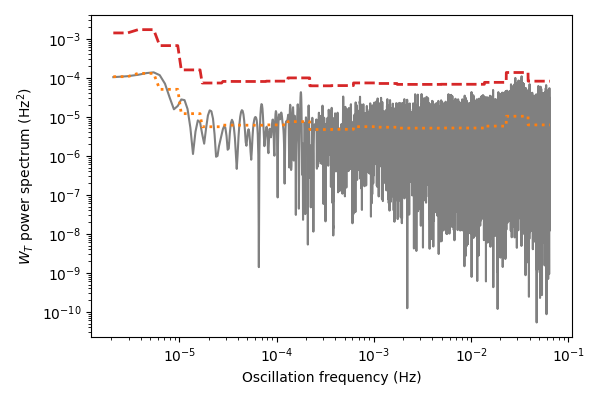

In [76]:
fs_bins = np.logspace(np.log10(np.min(fs) - 1e-10), np.log10(np.max(fs) + 1e-10), 20 + 1)
W_T_binned_indices = np.digitize(fs, fs_bins)
W_T_binned = []
for kk in range(1, len(fs_bins)):
    power_W_T_same_bin = power_W_T[W_T_binned_indices==kk]
    W_T_binned.extend([np.average(power_W_T_same_bin)] * len(power_W_T_same_bin))
W_T_binned = np.array(W_T_binned)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fs, power_W_T, label="data", color="gray")
ax.plot(fs, W_T_binned, label="binned average", color="C1", ls="dotted", linewidth=2)
global_95_bound = -np.log(1 - 0.95 ** (1/num_of_cycles)) * W_T_binned
ax.plot(fs, global_95_bound, label=f"95% confidence level", color="C3", linewidth=2, ls="dashed")
ax.set_ylabel("$W_T$ power spectrum (Hz$^2$)")
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")
#ax.legend()
plt.tight_layout()
plt.savefig("spectrum.pdf")
plt.show()

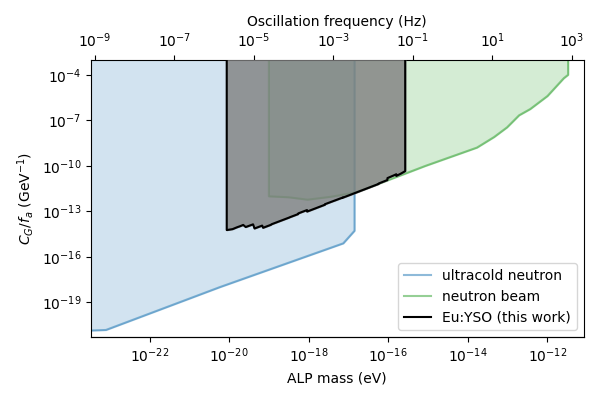

In [82]:
W_T_to_theta = 2.7 / 110e3 / 3.1
stochastic_factor = 3
inverse_fa_limits = inverse_fa_limit(fs, np.sqrt(global_95_bound * 2 / sensitivity_func(fs)) * W_T_to_theta) * stochastic_factor

fig, ax = plt.subplots(figsize=(6, 4))
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax1 = ax.secondary_xaxis("bottom", functions=(axion_frequency_to_mass, axion_mass_to_frequency))
counter = 0
for kk in exp_bounds:
    temp_x = np.transpose(exp_bounds[kk])[0]
    temp_y = np.transpose(exp_bounds[kk])[1]
    temp_x = np.append([temp_x[0]], temp_x)
    temp_y = np.append([1], temp_y)
    temp_x = np.append(temp_x, [temp_x[-1]])
    temp_y = np.append(temp_y, [1])
    ax.plot(temp_x, temp_y, label=kk, alpha=0.5, zorder=counter, color=f"C{counter}")
    ax.fill_between(np.transpose(exp_bounds[kk])[0], np.transpose(exp_bounds[kk])[1], 1, alpha=0.2, zorder=counter, color=f"C{counter}")
    counter += 1
    if counter == 1:
        counter += 1
ax.fill_between(fs, inverse_fa_limits, 1, zorder=counter, color="gray", alpha=0.8)
ax.plot(np.append(np.append(fs[0], fs), fs[-1]), np.append(np.append(1, inverse_fa_limits), 1), color="k", label="Eu:YSO (this work)", zorder=counter, alpha=1)
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_ylabel("$C_G / f_a$ (GeV${}^{-1}$)")
ax1.set_xscale("log")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim(0.5e-21, 1e-3)
ax.set_xlim(8e-10, 2e3)
ax.set_xticks([1e-9, 1e-7, 1e-5, 1e-3, 0.1, 10, 1e3])
ax1.set_xlabel("ALP mass (eV)")
ax.legend()
plt.tight_layout()
plt.savefig("exclusion.pdf")
plt.show()

## W_T periodgram and binned limit - log bins

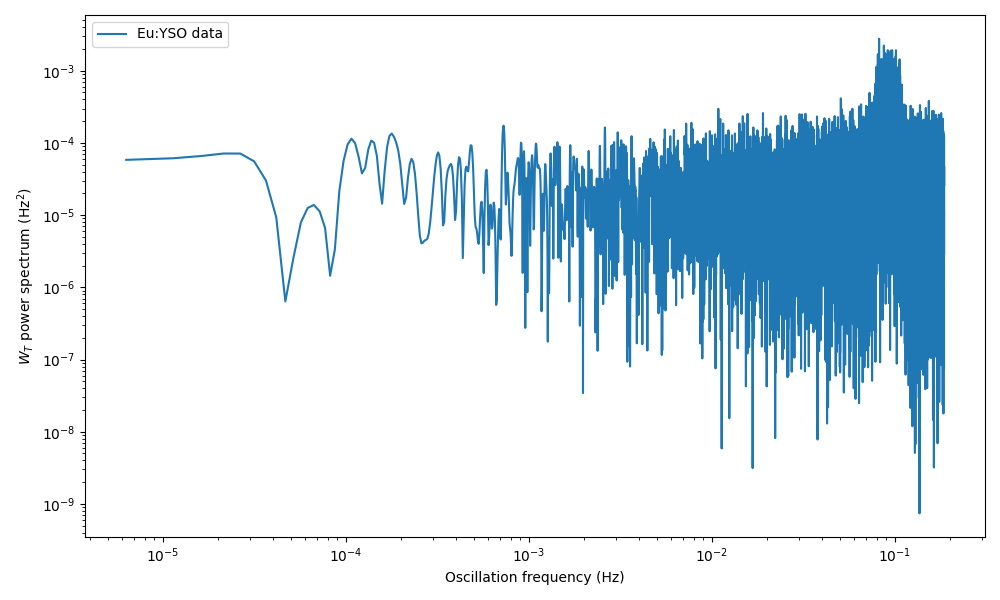

In [37]:
times = results[:, col_indices["start_time"]].astype(float)[mask]
W_T = unumpy.nominal_values(results[:, col_indices["W_T"]])[mask]
# W_T += np.sin(1e-4 * 2 * np.pi * times) * 0.2

W_T_uncs = np.std(W_T) * np.ones(len(W_T))  # assuming error bar is std of the data for every point
ls = LombScargle(times, W_T, normalization="psd")

min_freq = 0.25 / duration  # 4 times longer than the oscillation
max_freq = 1 / cycle_time_avg
fs, f_W_T_psd = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)
f_W_T_psd *= 2 / len(times)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fs, f_W_T_psd, label="Eu:YSO data")
ax.set_ylabel("$W_T$ power spectrum (Hz$^2$)")
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.show()

In [38]:
default_fs_bins = np.concatenate(
    [np.logspace(np.log10(np.min(fs)), np.log10(np.max(fs)), 100, endpoint=False), [np.max(fs) + 1e-10]]
)

W_T_binned_indices = np.digitize(fs, default_fs_bins)
fs_bin_start = []
fs_bin_end = []
W_T_binned = []

last_bin_closed = True
for kk in range(1, len(default_fs_bins)):
    if last_bin_closed:
        fs_bin_start.append(default_fs_bins[kk-1])
        W_T_binned.append([])
    W_T_binned[-1].extend(f_W_T_psd[W_T_binned_indices==kk])
    if len(W_T_binned[-1]) > 10:
        last_bin_closed = True
    else:
        last_bin_closed = False
    if last_bin_closed:
        fs_bin_end.append(default_fs_bins[kk])
fs_bin_start = np.array(fs_bin_start)
fs_bin_end = np.array(fs_bin_end)
fs_bin_center = (fs_bin_start + fs_bin_end) / 2
W_T_binned_avg = np.array([np.average(kk) for kk in W_T_binned])
W_T_binned_std = np.array([np.std(kk) for kk in W_T_binned])
W_T_binned_num = np.array([len(kk) for kk in W_T_binned])

In [39]:
len(fs_bin_end / fs_bin_start)

65

0.0018744969517545981
0.6749589892531885


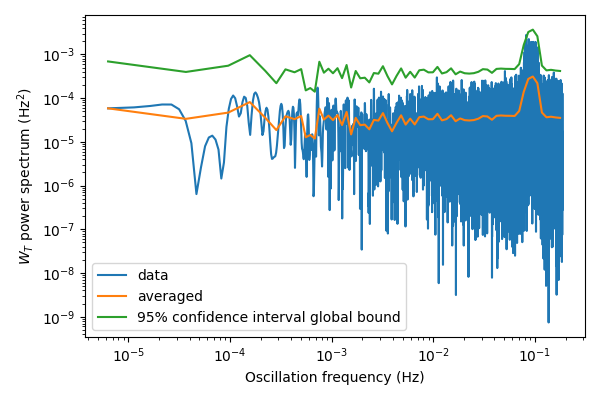

In [40]:

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fs, f_W_T_psd, label="data")
fs_bin_center = np.concatenate([[np.min(fs)], fs_bin_center])
W_T_binned_avg = np.concatenate([[f_W_T_psd[0]], W_T_binned_avg])
ax.plot(fs_bin_center, W_T_binned_avg, label="averaged")
# Z = 1.645  # single sided 95% std
# upper_limits_gaussian = W_T_binned_avg + W_T_binned_std * Z * np.sqrt(W_T_binned_num)
# ax.plot(fs_bin_end, upper_limits_gaussian, label="95% upper limit from the binned data - gaussian")
# upper_limits_exponential = -np.log(1 - 0.95 ** (1/W_T_binned_num)) * W_T_binned_avg  # exponential CDF = 1 - exp(-lambda x), mean = 1 / lambda.
#ax.plot(fs_bin_end, upper_limits_exponential, label="95% upper limit from the binned data - exponential")
upper_limits_exponential_global = -np.log(1 - (1 - 0.5733e-6 / 2) ** (1/len(times))) * np.average(f_W_T_psd)  # this may be wrong due to different data points are correlated. See Eq. 10 of the nEDM paper and text below.
print(upper_limits_exponential_global)
#ax.hlines([upper_limits_exponential_global], np.min(fs), np.max(fs), color="C7", label="95% confidence interval global bound")
print(upper_limits_exponential_global / np.max(f_W_T_psd))

upper_limits_exponential_global_using_local_amplitude = -np.log(1 - 0.95 ** (1/len(times))) * W_T_binned_avg
upper_limits_exponential_global_merged = np.array(upper_limits_exponential_global_using_local_amplitude)
upper_limits_exponential_global_merged[(upper_limits_exponential_global_merged < upper_limits_exponential_global)] = upper_limits_exponential_global
upper_limits_exponential_global_merged[(fs_bin_center < 1e-2)] = upper_limits_exponential_global
# fs_for_upper_limits_merged = np.concatenate([[np.min(fs)], fs_bin_center])
# upper_limits_exponential_global_merged = np.concatenate([[upper_limits_exponential_global], upper_limits_exponential_global_merged])
ax.plot(fs_bin_center, upper_limits_exponential_global_using_local_amplitude, label="95% confidence interval global bound")
ax.set_ylabel("$W_T$ power spectrum (Hz$^2$)")
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
#plt.savefig("spectrum.pdf")
plt.show()

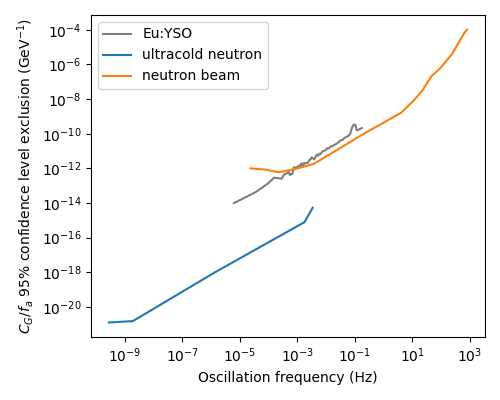

In [41]:
W_T_to_theta = 2.5e-5
inverse_fa_limits = inverse_fa_limit(fs_bin_center, np.sqrt(upper_limits_exponential_global_using_local_amplitude * 2) * W_T_to_theta)

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(fs_bin_center, inverse_fa_limits, color="C7", label="Eu:YSO")
for kk in exp_bounds:
    ax.plot(np.transpose(exp_bounds[kk])[0], np.transpose(exp_bounds[kk])[1], label=kk)
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_ylabel(f"$C_G / f_a$ 95% confidence level" + " exclusion (GeV$^{-1}$)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.savefig("exclusion.pdf")
plt.show()

## Extend to ~1.7 Hz

In [284]:
times = results[:, col_indices["start_time"]].astype(float)[mask]
W_T = unumpy.nominal_values(results[:, col_indices["W_T"]])[mask]
#W_T += np.sin(0.48 * 2 * np.pi * times) * 0.063

ls = LombScargle(times - times[0], W_T, normalization="psd")

min_freq = 4.0#0.5 / duration  # 2 times longer than the oscillation
max_freq = 4.4#8 / cycle_time_avg
fs, f_W_T_psd = ls.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq, samples_per_peak=7)
f_W_T_psd *= 2 * sample_time

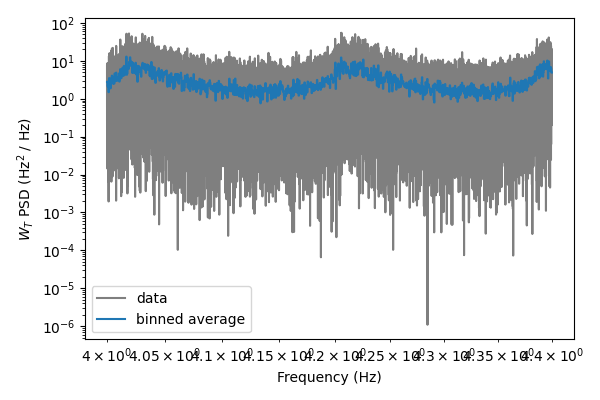

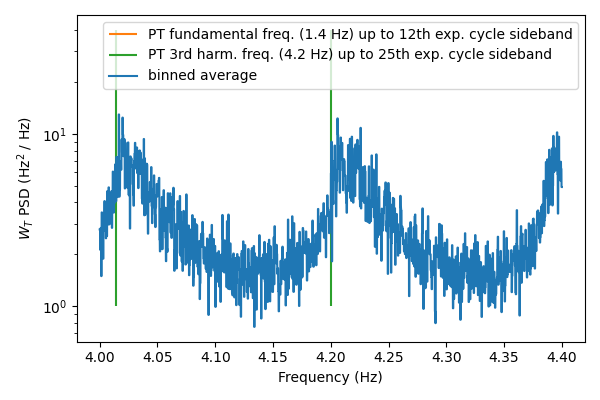

In [288]:
fs_bins = np.linspace(np.min(fs) - 1e-10, np.max(fs) + 1e-10, 1000 + 1)
W_T_binned_indices = np.digitize(fs, fs_bins)
W_T_binned = []
for kk in range(1, len(fs_bins)):
    f_W_T_psd_same_bin = f_W_T_psd[W_T_binned_indices==kk]
    W_T_binned.extend([np.average(f_W_T_psd_same_bin)] * len(f_W_T_psd_same_bin))
W_T_binned = np.array(W_T_binned)
W_T_avg_all = np.average(f_W_T_psd)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fs, f_W_T_psd, label="data", color="C7")
ax.plot(fs, W_T_binned, label="binned average")
global_95_bound = -np.log(1 - 0.95 ** (1/len(times))) * W_T_binned
#ax.plot(fs, global_95_bound, label=f"95% confidence level", color="gray")
ax.set_ylabel("$W_T$ PSD (Hz$^2$ / Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.show()


pt_freqs = []
for kk in range(0, 20):
    for ll in [1]:
        freq = abs(kk * cycle_frequency_avg - 1.4 * ll)
        if freq < 1.6:
            pt_freqs.append(freq)
fig, ax = plt.subplots(figsize=(6, 4))

pt_freqs = []
for kk in range(0, 13):
    for ll in [1]:
        freq = abs(kk * cycle_frequency_avg - 1.4 * ll)
        if freq < 4.4 and freq > 4.0:
            pt_freqs.append(freq)
ax.vlines(pt_freqs, 1., 40, color="C1", label="PT fundamental freq. (1.4 Hz) up to 12th exp. cycle sideband")
pt_freqs = []
for kk in range(0, 26):
    for ll in [3]:
        freq = abs(kk * cycle_frequency_avg - 1.4 * ll)
        if freq < 4.4 and freq > 4.0:
            pt_freqs.append(freq)
ax.vlines(pt_freqs, 1., 40, color="C2", label="PT 3rd harm. freq. (4.2 Hz) up to 25th exp. cycle sideband")
ax.plot(fs, W_T_binned, label="binned average")
ax.set_ylabel("$W_T$ PSD (Hz$^2$ / Hz)")
ax.set_xlabel("Frequency (Hz)")
ax.set_yscale("log")
ax.legend()
#ax.set_xlim(0.05, 1.5)
plt.tight_layout()
plt.show()

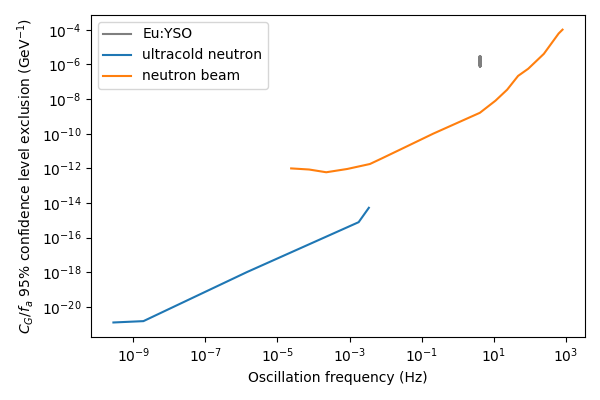

In [286]:
W_T_to_theta = 2.5e-5
inverse_fa_limits = inverse_fa_limit(fs, np.sqrt(global_95_bound * 2) * W_T_to_theta)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(fs, inverse_fa_limits, color="C7", label="Eu:YSO")
for kk in exp_bounds:
    ax.plot(np.transpose(exp_bounds[kk])[0], np.transpose(exp_bounds[kk])[1], label=kk)
ax.set_xlabel("Oscillation frequency (Hz)")
ax.set_ylabel(f"$C_G / f_a$ 95% confidence level" + " exclusion (GeV$^{-1}$)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.savefig("exclusion.pdf")
plt.show()

## power aliasing

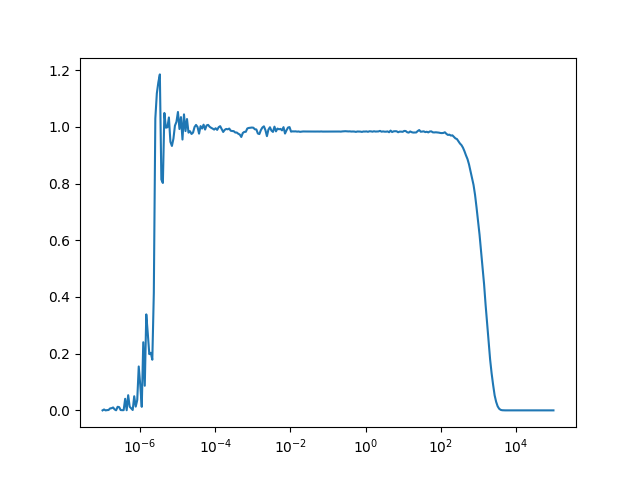

In [40]:
times_test = times
max_powers_test = []
freqs_test = np.logspace(-7, 5, 300)
for freq_test in freqs_test:
    signal_test = np.sin(2 * np.pi * freq_test * (times_test + 1e-4 * np.random.normal(size=len(times_test)))) * np.sqrt(2)
    ls_test = LombScargle(times_test, signal_test, normalization="psd")
    #max_powers_test.append(ls_test.power(freq_test) * 2 / len(times_test))
    if freq_test < 1e-2:
        max_powers_test.append(np.max(ls_test.autopower(minimum_frequency=freq_test * (1-1e-3), maximum_frequency=freq_test*(1+1e-3))[1]) * 2 / len(times_test))
    else:
        max_powers_test.append(np.max(ls_test.autopower(minimum_frequency=freq_test -1.1e-3, maximum_frequency=freq_test+1e-3)[1]) * 2 / len(times_test))
fig, ax = plt.subplots()
ax.plot(freqs_test, max_powers_test)
ax.set_xscale("log")
plt.show()

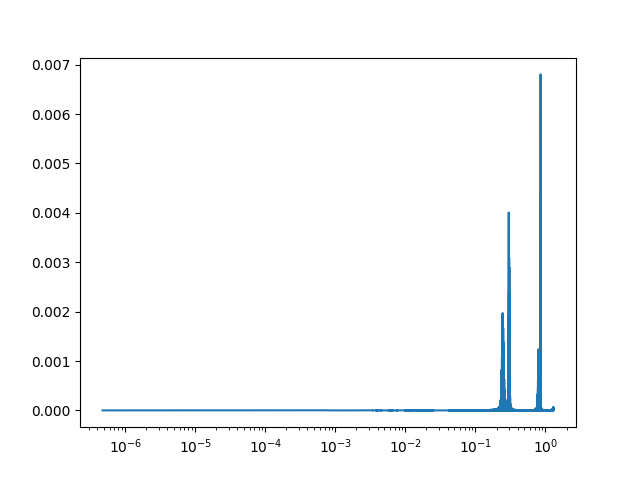

In [41]:
times_test = times
freq_test = 1.4
signal_test = np.sin(2 * np.pi * freq_test * (times_test + 1e-4* np.random.normal(size=len(times_test)))) * np.sqrt(2)
ls_test = LombScargle(times_test, signal_test, normalization="psd")
freq_tests, max_powers_test = ls_test.autopower()
max_powers_test *= 2 / len(times_test)
fig, ax = plt.subplots()
ax.plot(freq_tests, max_powers_test)
ax.set_xscale("log")
plt.show()

## Exponential distribution confirmation

7.855527131345174e-05


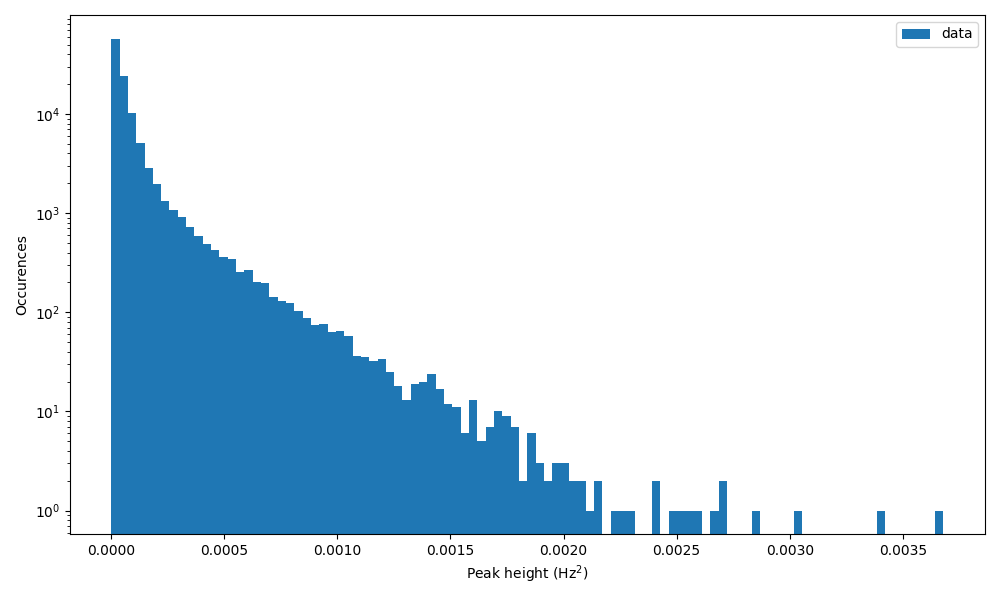

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(f_W_T_psd, label="data", bins=100)
# filter = np.zeros(len(f_W_T_psd), dtype=bool)
# filter = ((fs < 1.40004) | (fs > 1.4003)) & ((fs < 2.534) | (fs > 2.566))
# ax.hist(f_W_T_psd[filter], label="data", bins=100)
print(np.average(f_W_T_psd))
#ax.plot([0, 0.00132], [1.8e6, 1e-2])
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("Peak height (Hz$^2$)")
ax.set_ylabel("Occurences")
plt.tight_layout()
plt.show()

C:\Users\mingy\AppData\Local\Temp\ipykernel_12244\2380455247.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


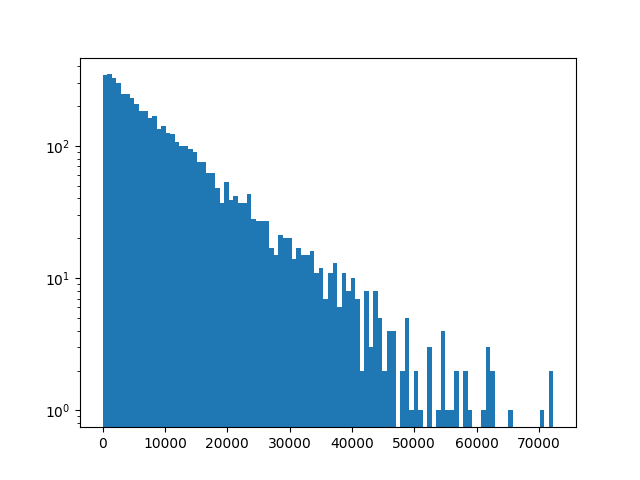

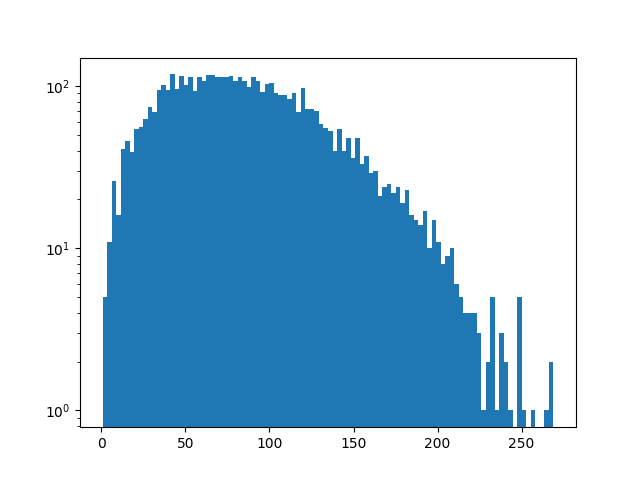

In [43]:
test_t_data = np.random.normal(size=10000)
test_ts = np.arange(len(test_t_data))
test_f_data = np.fft.rfft(test_t_data)
fig, ax = plt.subplots()
ax.hist(np.abs(test_f_data)**2, bins=100)
ax.set_yscale("log")
plt.show()
fig, ax = plt.subplots()
ax.hist(np.abs(test_f_data), bins=100)
ax.set_yscale("log")
plt.show()

## astropy 95%

0.22372892144829667
0.20540118657579093
0.22406126571548085


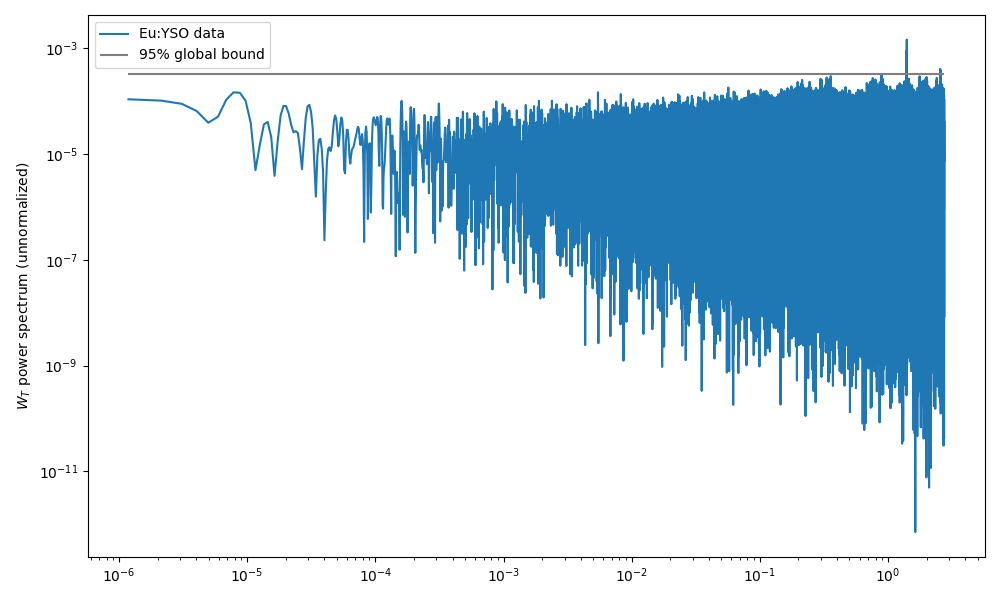

In [44]:
ls1 = LombScargle(times, W_T)

min_freq = 0.25 / duration  # 4 times longer than the oscillation
max_freq = 5 / cycle_time_avg
fs1, f_W_T_psd1 = ls1.autopower(minimum_frequency=min_freq, maximum_frequency=max_freq)

f_W_T_psd1_fal = ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq)
print(ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq, method="baluev") / np.max(f_W_T_psd1))
print(ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq, method="naive") / np.max(f_W_T_psd1))
print(ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq, method="davies") / np.max(f_W_T_psd1))
# print(ls1.false_alarm_level(0.05, minimum_frequency=min_freq, maximum_frequency=max_freq, method="bootstrap") / np.max(f_W_T_psd1))  # takes forever
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(fs1, f_W_T_psd1, label="Eu:YSO data")
ax.hlines([f_W_T_psd1_fal], np.min(fs1), np.max(fs1), label="95% global bound", color="C7")
ax.set_ylabel("$W_T$ power spectrum (unnormalized)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.tight_layout()
plt.show()